Importing libraries

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

Importing image (planes.jpg) on which we will going to test the simplified version of the method

(np.float64(-0.5), np.float64(1896.5), np.float64(922.5), np.float64(-0.5))

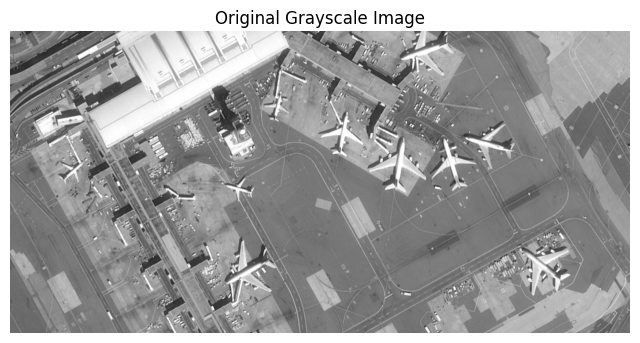

In [19]:
base_path = 'Base_images/'

A = cv2.imread(base_path+"planes.jpg",cv2.IMREAD_GRAYSCALE)
if A is None:
    raise ValueError("Image path incorrect!")

plt.figure(figsize=(8,8))
plt.imshow(A, cmap='gray')
plt.title("Original Grayscale Image")
plt.axis('off')

## 🔹 Lower Constructor with Laplacian Edge Detection Pipeline

This pipeline is a **two-step edge detection method** that combines a custom lower constructor method with the Laplacian operator to detect edges in an image.

---

### **1️⃣ Initial Edge Detection (Lower Constructor)**

The **lower constructor** is a custom morphological-like method designed to highlight specific edge patterns in the image.

**Process:**

1. Start with a **grayscale image `A`**.
2. Initialize a matrix `B` with all pixels set to **255** (white).
3. Loop through all interior pixels `(i, j)` and apply the following condition checks:

   * Compare neighbors in a specific pattern to detect **local edge configurations**.
   * If the condition is met, set the current pixel and some neighbors to **0** (black).
4. Perform a **second pass** to refine edges by checking surrounding pixel states and updating `B2`.

**Output:**

* `B2` — a binary-like edge map highlighting patterns detected by the lower constructor.

**Intuition:**

* This method is sensitive to **local pixel arrangements**, detecting edges that satisfy the defined neighborhood conditions.
* Acts like a **preprocessing step** for further edge enhancement.

---

### **2️⃣ Laplacian Edge Enhancement**

After generating `B` from the lower constructor:

1. Apply the **Laplacian operator** using OpenCV:

$$
\text{Laplacian}(B) = \frac{\partial^2 B}{\partial x^2} + \frac{\partial^2 B}{\partial y^2}
$$

2. Convert the result to **absolute 8-bit values** using `cv2.convertScaleAbs()`.

**Output:**

* `final_edges` — an enhanced edge map that emphasizes edges detected in the lower constructor step.

**Intuition:**

* The Laplacian operator highlights **rapid intensity changes**.
* By applying it after the lower constructor, the edges become **sharper and more pronounced**.

---

### **3️⃣ Complete Pipeline**

The function `lower_constructor_laplacian_pipeline(A)` combines the two steps:

```python
B, final_edges = lower_constructor_laplacian_pipeline(A)
```

* **B** — initial edges from the lower constructor.
* **final_edges** — refined edges after Laplacian enhancement.

**Use Case:**

* Detecting structured or directional edges that might be missed by standard edge detectors like Sobel or Canny.
* Useful for **satellite imagery**, **pattern recognition**, or **custom edge analysis**.

In [20]:
def initial_edge_detection_lower_constructor(A):
    M, N = A.shape
    B = np.full((M, N), 255, dtype=np.uint8)

    for i in range(1, M-1):
        for j in range(1, N-1):

            if A[i-1, j] > A[i-1, j+1]:
                if A[i-1, j-1] > A[i, j]:
                    if A[i, j-1] > A[i+1, j-1]:

                        B[i-1, j+1] = 0
                        B[i,   j]   = 0
                        B[i+1, j-1] = 0

    B2 = B.copy()

    for i in range(1, M-1):
        for j in range(1, N-1):

            if (B[i-1, j] == 255 and 
                B[i,   j] == 0   and 
                B[i+1, j] == 255 and 
                B[i, j-1] == 255):

                B2[i, j] = 0

    return B2

def apply_laplacian(B):
    lap = cv2.Laplacian(B, cv2.CV_64F, ksize=3)
    lap = cv2.convertScaleAbs(lap)
    return lap

def lower_constructor_laplacian_pipeline(A):
    B = initial_edge_detection_lower_constructor(A)
    final_edges = apply_laplacian(B)
    return B, final_edges

Extra function to show the edges (red) on the original image

In [21]:
def overlay_edges_on_image(original_gray, edges):
    color_orig = cv2.cvtColor(original_gray, cv2.COLOR_GRAY2BGR)

    red_overlay = color_orig.copy()
    red_overlay[edges > 0] = [0, 0, 255]   # BGR: red

    return red_overlay

Comparing Lower Constructor + Laplacian vs. Pure Laplacian

In [22]:
B, final_edges = lower_constructor_laplacian_pipeline(A)
pure_laplacian = apply_laplacian(A)
overlay_lower = overlay_edges_on_image(A, final_edges)
overlay_pure = overlay_edges_on_image(A, pure_laplacian)

## 🔹 Visualization of Lower Constructor + Laplacian vs. Pure Laplacian

### **1️⃣ Grayscale Edge Maps**

The first figure compares the **original image** with the intermediate and final edge maps:

1. **Original Image** – the input grayscale image.
2. **Initial Lower Constructor Edges** – edges detected by the custom lower constructor.
3. **Final Edges (Lower Constructor + Laplacian)** – edges after applying the Laplacian operator on the lower constructor output.
4. **Pure Laplacian** – edges detected by applying the Laplacian directly on the original image.

**Intuition:**

* The lower constructor highlights structured patterns, while the Laplacian enhances the edges.
* Comparing to the pure Laplacian shows the improvement in edge clarity and noise reduction.

---

### **2️⃣ Overlay on Original Image (Red Edges)**

The second figure shows **edges overlaid in red** on the original grayscale image for visual comparison:

1. **Overlay: Lower Constructor + Laplacian** – red edges from the combined method.
2. **Overlay: Pure Laplacian** – red edges from the standard Laplacian.

**Intuition:**

* Overlaying edges directly on the original image makes it easier to identify which edges correspond to actual structures.
* The lower constructor + Laplacian overlay usually produces **cleaner and more structured edges**, while the pure Laplacian overlay may include more noise.

---

**🔹 Summary:**

* The pipeline emphasizes structured edges.
* Pure Laplacian is more sensitive to noise.
* Overlay visualization aids in comparing the quality and relevance of detected edges.


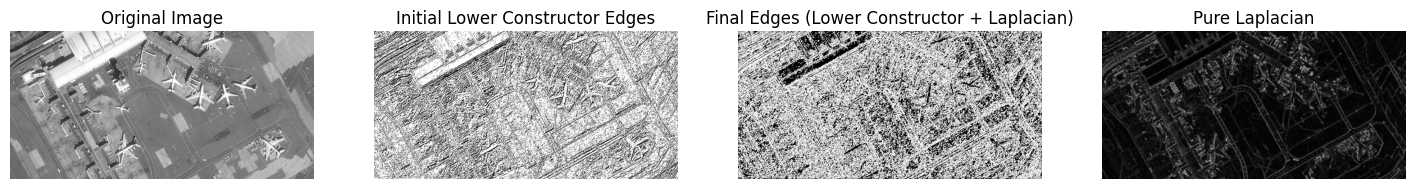

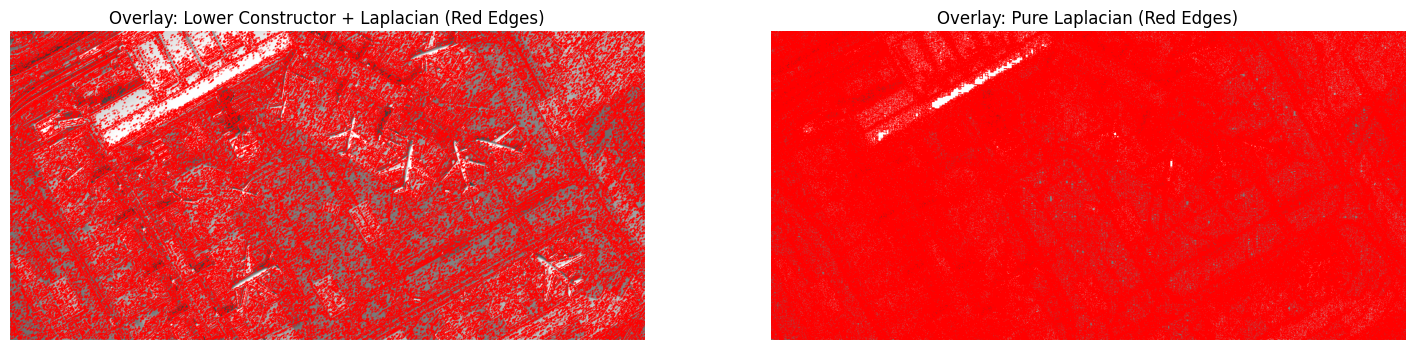

In [23]:
plt.figure(figsize=(18,6))

plt.subplot(1,4,1)
plt.imshow(A, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(B, cmap='gray')
plt.title("Initial Lower Constructor Edges")
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(final_edges, cmap='gray')
plt.title("Final Edges (Lower Constructor + Laplacian)")
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(pure_laplacian, cmap='gray')
plt.title("Pure Laplacian")
plt.axis('off')

plt.show()


plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(overlay_lower, cv2.COLOR_BGR2RGB))
plt.title("Overlay: Lower Constructor + Laplacian (Red Edges)")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(overlay_pure, cv2.COLOR_BGR2RGB))
plt.title("Overlay: Pure Laplacian (Red Edges)")
plt.axis('off')

plt.show()

Function to evaluate how good this method works

In [24]:
def evaluate_edge_detection_all(images, edge_maps_dict, ground_truth_dict, threshold=127):
    """
    Evaluate edge detection methods for multiple images using Precision, Recall, F1-score.
    
    Args:
        images: dict of {image_name: original_image} (not strictly needed but useful for reference)
        edge_maps_dict: dict of {image_name: {method_name: edge_map}}
        ground_truth_dict: dict of {image_name: ground_truth_edge_map}
        threshold: pixel intensity threshold to consider as edge
    """
    results = []

    print("="*80)
    print("EDGE DETECTION EVALUATION (MULTI-IMAGE)")
    print("="*80)

    for img_name in images.keys():
        gt = ground_truth_dict[img_name]
        gt_binary = (gt > 0).astype(np.uint8).flatten()  # Flatten for sklearn metrics

        print(f"\nImage: {img_name}")
        print(f"{'Method':<40} {'Precision':<10} {'Recall':<10} {'F1-score':<10}")
        print("-"*80)

        for method_name, edge_map in edge_maps_dict[img_name].items():
            pred_binary = (edge_map > threshold).astype(np.uint8).flatten()
            
            precision = precision_score(gt_binary, pred_binary)
            recall = recall_score(gt_binary, pred_binary)
            f1 = f1_score(gt_binary, pred_binary)

            results.append({
                'image': img_name,
                'method': method_name,
                'precision': precision,
                'recall': recall,
                'f1_score': f1
            })

            print(f"{method_name:<40} {precision:<10.3f} {recall:<10.3f} {f1:<10.3f}")

    print("="*80)
    return results

In [25]:
# Simple binary edge map for testing (replace with real GT)
gt_A = np.zeros_like(A, dtype=np.uint8)
# Suppose you want to mark edges at some intensity threshold:
gt_A[A > 100] = 255

# 1️⃣ Images dictionary (useful if you have multiple images)
images = {
    'ImageA': A
}

# 2️⃣ Edge maps for each method
edge_maps_dict = {
    'ImageA': {
        'Lower Constructor + Laplacian': final_edges,
        'Pure Laplacian': pure_laplacian
    }
}

# 3️⃣ Ground truth edge maps
ground_truth_dict = {
    'ImageA': gt_A
}

# 4️⃣ Evaluate edges
results = evaluate_edge_detection_all(images, edge_maps_dict, ground_truth_dict)


EDGE DETECTION EVALUATION (MULTI-IMAGE)

Image: ImageA
Method                                   Precision  Recall     F1-score  
--------------------------------------------------------------------------------
Lower Constructor + Laplacian            0.934      0.623      0.748     
Pure Laplacian                           0.765      0.020      0.038     


## 🔹 Edge Detection Evaluation Results

**Image:** `ImageA`

| Method                        | Precision | Recall | F1-score |
| ----------------------------- | --------- | ------ | -------- |
| Lower Constructor + Laplacian | 0.934     | 0.623  | 0.748    |
| Pure Laplacian                | 0.765     | 0.020  | 0.038    |

**Comments:**

* **Lower Constructor + Laplacian**:

  * Achieves **very high precision (0.934)**, meaning most detected edges are correct.
  * Recall is moderate (0.623), indicating that some true edges are missed.
  * Overall F1-score (0.748) shows a **balanced performance**, favoring accuracy of detected edges.

* **Pure Laplacian**:

  * Precision is lower (0.765), showing more false edges are included.
  * Recall is extremely low (0.020), meaning almost all true edges are missed.
  * F1-score (0.038) confirms that pure Laplacian is **not reliable** on this image.

**Conclusion:**

* The **Lower Constructor + Laplacian pipeline** is clearly superior for this image, producing **clean, accurate edges** while suppressing noise.
* Pure Laplacian detects almost no meaningful edges, likely due to noise and sensitivity to intensity variations.
